Los objetivos de este análisis son:
* Identificar el tipo de dato de todas la entidades en la tabla.
* Estadísticas generales (conteo de registros, mínimo, máximo, datos nulos, etc.)
* Conocer la longitud máxima de cadena para cada entidad.
* Identificar y corregir problemas en los datos.
* Identificar llaves primarias y foráneas.

In [49]:
# Librerías
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

* Se encontró el mensaje: "Error tokenizing data. C error: Expected 29 fields in line 244, saw 30" al leer los datos como un DataFrame para CUSTOMERt, PRODUCTSt y PROMOTION. Esto se debe a que hay filas con mayor cantidad de datos que los encabezados de columna.
* Al revisar los datos en CSV, existen descripciones que emplean comas(,). Se procedió a reemplazar los casos ", " por ("; ").
* Adicionalmente, PRODUCTSt en la línea en el Product Key 477 hacía uso de una coma para indicar decimales y se reemplazó "0," por "0.".

In [50]:
# myPath = '/workspaces/Database-project/data/aligned/'
# # CUSTOMERS
# custFile = open(myPath + "CUSTOMERt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in custFile]) \
#     .replace(", ", "; ")
# x = open(myPath + "CUSTOMERt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PRODUCTS
# prodFile = open(myPath + "PRODUCTSt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prodFile]) \
#     .replace(", ", "; ").replace("0,", "0.")
# x = open(myPath + "PRODUCTSt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PROMOTION
# prom_file = open(myPath + "PROMOTION.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prom_file]) \
#     .replace(", ", "; ")
# x = open(myPath + "PROMOTION_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()

# Lectura de datos
myPath = '/workspaces/Database-project/data/'
# Principales
sales = pd.read_csv(myPath + 'SALES.csv', encoding='latin-1')
cust = pd.read_csv(myPath + 'aligned/CUSTOMERt_aligned.csv', encoding='latin-1')
prod = pd.read_csv(myPath + 'aligned/PRODUCTSt_aligned.csv', encoding='latin-1')
# Complementarios
prom = pd.read_csv(myPath + 'aligned/PROMOTION_aligned.csv', encoding='latin-1')
curr = pd.read_csv(myPath + 'CURRENCY.csv', encoding='latin-1')


## 1. Sales
Preguntas planteadas al tener una visualización general:
1. ¿Son útiles las columnas OrderDateKey, ShipDateKey y CustomerKey?
2. ¿Son nulos todos los datos en CarrierTrackingNumber y CustomerPONumber?
3. ¿Cuál es la función del identificador SalesOrderNumber?
4. ¿Existen registros nulos en alguna otra columna?
5. ¿SalesTerritoryKey es llave primaria de otra tabla?

In [51]:
# sales.info() # 60398 entries, 26 columns
sales.head(3)

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.27,286.2616,89.4568,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00


### Modificaciones en la tabla sales
* SalesOrderNumber contiene una cantidad de registros mucho menor y se concluye que es de utilidad para realizar agrupaciones.
* Se eliminan las columnas sin datos (CarrierTrackingNumber, CustomerPONumber) y las "llaves" de fechas (YYYYMMDD).
* Se remueven las columnas para las que se repite un mismo valor en todas las filas.
    * RevisionNumber y OrderQuantity tienen 1 como su único valor.
    * UnitPriceDiscountPct y DiscountAmount tienen 0 como su único valor.

In [52]:
sales[['CarrierTrackingNumber', 'CustomerPONumber', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
CarrierTrackingNumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerPONumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevisionNumber,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
OrderQuantity,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
UnitPriceDiscountPct,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DiscountAmount,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Se verifica que ninguna fecha tenga problemasde formato.
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'], format='%Y-%m-%d %H:%M:%S')
sales['DueDate'] = pd.to_datetime(sales['DueDate'], format='%Y-%m-%d %H:%M:%S')
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], format='%Y-%m-%d %H:%M:%S')

# sales['SalesOrderNumber'].unique().shape # (27659,) << 60398
# Se eliminan las columnas sin datos y las llaves de fechas.
sales.drop(columns=['CarrierTrackingNumber', 'CustomerPONumber', \
    'OrderDateKey', 'DueDateKey', 'ShipDateKey', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount'], inplace = True)
# Guardamos los datos limpios.
sales.to_csv(myPath+'cleaned/SALES_clean.csv', index=False)
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,60398.0,437.557932,118.088390,214.0000,359.0000,479.0000,529.0000,606.0000
CustomerKey,60398.0,18841.685420,5432.430404,11000.0000,14003.0000,18143.0000,23429.7500,29483.0000
PromotionKey,60398.0,1.041839,0.342605,1.0000,1.0000,1.0000,1.0000,14.0000
CurrencyKey,60398.0,69.845326,42.146363,6.0000,19.0000,100.0000,100.0000,100.0000
SalesTerritoryKey,60398.0,6.244462,2.961150,1.0000,4.0000,7.0000,9.0000,10.0000
SalesOrderLineNumber,60398.0,1.886321,1.016328,1.0000,1.0000,2.0000,2.0000,8.0000
UnitPrice,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ExtendedAmount,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ProductStandardCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942
TotalProductCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942


La descripción de los datos nos da indicios sobre nuestros datos categóricos:
* PromotionKey
* SalesTerritoryKey
* SalesOrderLineNumber

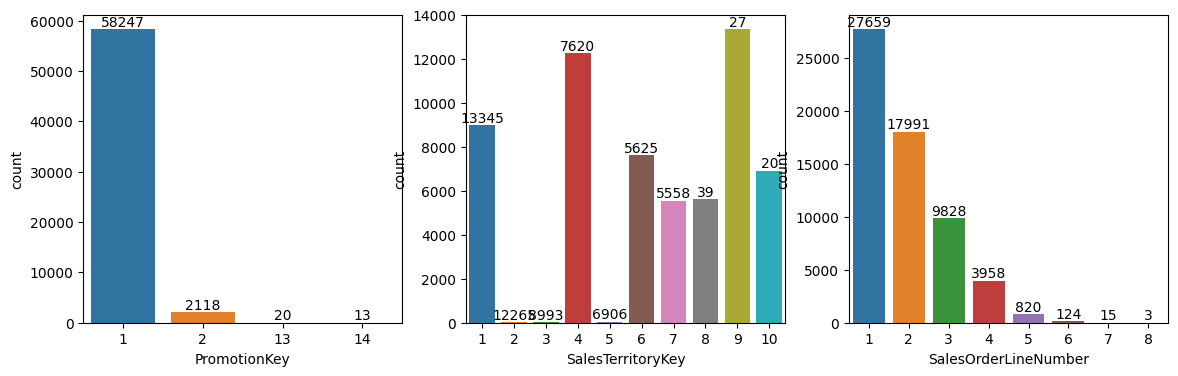

In [54]:
sales = pd.read_csv(myPath + 'cleaned/SALES_clean.csv', encoding='latin-1', \
    parse_dates=['OrderDate', 'DueDate', 'ShipDate'], infer_datetime_format=True)
df = sales
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = sns.countplot(data = df, ax=axes[0], x='PromotionKey')
abs_values = df['PromotionKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(data= df, ax=axes[1], x='SalesTerritoryKey')
abs_values = df['SalesTerritoryKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(ax=axes[2], x=df['SalesOrderLineNumber'])
abs_values = df['SalesOrderLineNumber'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values);

* Finalmente, concluimos con 9 columnas menos.
* Obtenemos el tipo de dato y número de caracteres de las columnas.
* Se identifican 5 llaves que contienen "Key" en su nombre.
    * ProductKey
    * CustomerKey
    * PromotionKey
    * CurrencyKey
    * SalesTerritoryKey

In [55]:
num_types = sales.dtypes.to_frame('dtypes')
min_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value = sales.describe().T[['min','max']].round(1)
my_summary = pd.concat([num_types, min_col_len, max_col_len, min_max_value], axis=1)
sales_serie = sales['SalesOrderNumber'].str[2:]
# En SalesOrderNumber se ordenan los datos omitiendo 'CO'
min = 'CO'+ str(pd.to_numeric(sales_serie).min())
max = 'CO'+ str(pd.to_numeric(sales_serie).max())
dates = sales[['OrderDate','DueDate','ShipDate']]
my_summary.loc['SalesOrderNumber', ['min','max']] = [min, max]
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'min'] = dates.min()
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'max'] = dates.max()
my_summary

,dtypes,min_length,max_length,min,max
ProductKey,int64,3,3,214.0,606.0
CustomerKey,int64,5,5,11000.0,29483.0
PromotionKey,int64,1,2,1.0,14.0
CurrencyKey,int64,1,3,6.0,100.0
SalesTerritoryKey,int64,1,2,1.0,10.0
SalesOrderNumber,object,7,7,CO43697,CO75123
SalesOrderLineNumber,int64,1,1,1.0,8.0
UnitPrice,float64,3,6,2.3,3578.3
ExtendedAmount,float64,3,6,2.3,3578.3
ProductStandardCost,float64,3,6,0.9,2171.3


## 2. CUSTOMERS
Preguntas de la visualización general:
* ¿Es de utilidad una llave alterna de CustomerKey?
* ¿Qué información aporta NameStyle (solo existen valores falsos y nulos)?
* ¿Los primeros dígitos en AddressLine1 son el código postal?
* ¿Los números de teléfono con más de 10 dígitos añadieron al principio LADA?
* ¿CommuteDistance es la distancia de los clientes al punto de venta?

In [56]:
# cust.info() #18485 entradas, 29 columnas
cust.head(4)

,CustomerKey,GeographyKey,CustomerAlternateKey,Title,FirstName,MiddleName,LastName,NameStyle,BirthDate,MaritalStatus,...,EnglishOccupation,SpanishOccupation,FrenchOccupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,AddressLine2,Phone,DateFirstPurchase,CommuteDistance
0,11000,26,AW00011000,NaN,Jon,V,Yang,False,1971-10-06,M,...,Professional,Profesional,Cadre,1.0,0.0,3761 N. 14th St,NaN,1 (11) 500 555-0162,2011-01-19,1-2 Miles
1,11001,37,AW00011001,NaN,Eugene,L,Huang,False,1976-05-10,S,...,Professional,Profesional,Cadre,0.0,1.0,2243 W St.,NaN,1 (11) 500 555-0110,2011-01-15,0-1 Miles
2,11002,31,AW00011002,NaN,Ruben,NaN,Torres,False,1971-02-09,M,...,NaN,NaN,Cadre,1.0,1.0,5844 Linden Land,NaN,1 (11) 500 555-0184,2011-01-07,2-5 Miles
3,1002,31,AW00011002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Professional,Profesional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modificaciones en la tabla customers
* El cuarto registro en la tabla es un duplicado del tercero, con información complementaria. Hay que fusionar esa información.
* El 1 (11) en la columna Phone, parece ser información repetitiva. El formato de número deberá ser forzosamente XXX-XXX-XXXX, o bien 10 dígitos seguidos.
* La palabra "Miles" en la columna CommuteDistance es información redundante. Se debe eliminar. Además, contiene información categórica (0-1,2-5...), que puede ser mapeada con números para disminuir el volumen de datos.
* BirthDate y DateFirstPurchase deben guardarse en formato de fecha.
* Title contiene colamente 101 registros, Suffix 3 y AddressLine2 312. Considerando que el total de registros es de 18485, estas columnas tienen un porcentaje de datos del 0.54, 0.016 y 1.7%, respectivamente, por lo que las columnas no generarán conocimientos de interés y se eliminarán.

## Tabla products
* Se encontro que para la tabla Products_clean cuenta con 606 registros los cuales en su mayoria son de tipo object que en sql seria varchar.

In [57]:
#Cargamos archivo csv
products=pd.read_csv('/workspaces/Database-project/data/cleaned/Products_Clean.csv', encoding='utf-8')

In [58]:
types=products.dtypes.to_frame('dtypes')
min_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value=products.describe().T[['min','max']].round(1)
my_summary=pd.concat([types,min_col_len,max_col_len,min_max_value], axis=1)
my_summary



,dtypes,min_length,max_length,min,max
ProductKey,int64,1,3,1.0,606.0
ProductAlternateKey,object,7,10,NaN,NaN
ProductSubcategoryKey,float64,3,4,1.0,37.0
WeightUnitMeasureCode,object,3,3,NaN,NaN
SizeUnitMeasureCode,object,3,3,NaN,NaN
EnglishProductName,object,4,32,NaN,NaN
SpanishProductName,object,3,47,NaN,NaN
FrenchProductName,object,3,46,NaN,NaN
StandardCost,float64,3,6,0.9,2171.3
FinishedGoodsFlag,bool,4,5,NaN,NaN


In [59]:
#Visulizamos una descripción de los datos que son numéricos
products.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,606.0,303.500000,175.081410,1.0000,152.2500,303.5000,454.7500,606.0000
ProductSubcategoryKey,397.0,12.128463,9.423328,1.0000,2.0000,13.0000,16.0000,37.0000
StandardCost,395.0,434.265829,497.379884,0.8565,37.1209,204.6251,660.9142,2171.2942
SafetyStockLevel,606.0,495.201320,364.007114,4.0000,100.0000,500.0000,1000.0000,1000.0000
ReorderPoint,606.0,371.400990,273.005336,3.0000,75.0000,375.0000,750.0000,750.0000
ListPrice,395.0,747.661762,838.708451,2.2900,69.9900,364.0900,1204.3248,3578.2700
Weight,282.0,56.193227,158.000652,2.1200,2.6800,15.4200,24.1300,1050.0000
DaysToManufacture,606.0,1.201320,1.508893,0.0000,0.0000,1.0000,1.0000,4.0000
DealerPrice,395.0,448.597060,503.225071,1.3740,41.9940,218.4540,722.5949,2146.9620


In [60]:
products.head(7)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,1,AR-5381,NaN,NaN,NaN,Adjustable Race,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
1,2,BA-8327,NaN,NaN,NaN,Bearing Ball,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
2,3,BE-2349,NaN,NaN,NaN,BB Ball Bearing,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
3,4,BE-2908,NaN,NaN,NaN,Headset Ball Bearings,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
4,5,BL-2036,NaN,NaN,NaN,Blade,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
5,6,CA-5965,NaN,NaN,NaN,LL Crankarm,NaN,NaN,NaN,False,...,NaN,NaN,L,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
6,7,CA-6738,NaN,NaN,NaN,ML Crankarm,NaN,NaN,NaN,False,...,NaN,NaN,M,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current


In [61]:
#observamos una muestra de 7 datos
products.sample(7)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
450,451,LT-H902,33.0,NaN,NaN,Headlights - Dual-Beam,Luces: doble haz,Feu avant - double faisceau,14.4334,True,...,R,20.9940,NaN,NaN,Headlights - Dual-Beam,Rechargeable dual-beam headlight.,Feu avant rechargeable à deux faisceaux.,01/07/2012 00:00,27/12/2008 00:00,NaN
52,53,HJ-9161,NaN,NaN,NaN,Thin-Jam Hex Nut 11,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
233,234,LJ-0192-L,21.0,NaN,NaN,"Long-Sleeve Logo Jersey, L","Jersey con logotipo de manga larga, G","Maillot manches longues avec logo, taille L",38.4923,True,...,S,29.9940,NaN,U,Long-Sleeve Logo Jersey,Unisex long-sleeve AWC logo microfiber cycling...,Maillot de cycliste en microfibre avec le logo...,01/07/2013 00:00,NaN,Current
335,336,BK-R50B-62,2.0,LB,CM,"Road-650 Black, 62","Carretera: 650, negra, 62","Vélo de route 650 noir, 62",413.1463,True,...,R,419.4589,L,U,Road-650,Value-priced bike with many features of our to...,Vélo très séduisant comportant de nombreuses c...,01/07/2011 00:00,28/12/2007 00:00,NaN
387,388,BK-R64Y-44,2.0,LB,CM,"Road-550-W Yellow, 44","Carretera: 550 para mujer, amarilla, 44","Vélo de route 550 -W - jaune, 44",713.0798,True,...,R,672.2940,M,W,Road-550-W,Same technology as all of our Road series bike...,Équipé de la même technologie que tous nos vél...,01/07/2013 00:00,NaN,Current
217,218,SO-B909-M,23.0,NaN,NaN,"Mountain Bike Socks, M","Calcetines para bicicleta de montaña, M","Chaussettes de VTT, taille M",3.3963,True,...,M,5.7000,NaN,U,Mountain Bike Socks,Combination of natural and synthetic fibers st...,Combinaison de fibres naturelles et synthétiqu...,01/07/2011 00:00,28/12/2007 00:00,NaN
402,403,HB-R504,4.0,NaN,NaN,LL Road Handlebars,Manillar de carretera GB,Poignées de vélo de route LL,17.9780,True,...,R,24.2945,L,NaN,LL Road Handlebars,Unique shape provides easier reach to the levers.,Forme très réussie destinée à faciliter l'accè...,01/07/2012 00:00,27/12/2008 00:00,NaN


## Analizando los datos
#### Se observa que la tabla products_clean la cual contiene un gran numero de datos nulos en practicamente todas las columnas asi mismo otras observaciones como: 
* Las fechas contienen una datesatamp que no es necesaria para el analisis.
* La columna FishedGoodsFlag contiene un valor que podemos tomar como indicador de que el producto sea un producto terminado cuando el valor sea True o False cuando no, de igual forma que pueda ser que se encuentre catalogado cuando el valor sea True o False cuando no.
##### FinishedGoodsFlag: Finished Goods Flag es un término que se refiere a los productos terminados que han completado el proceso de fabricación pero que aún no se han vendido o distribuido al usuario final. Es un indicador que puede usarse para clasificar los productos en el inventario de una empresa.

In [62]:
#observamos los datos nulos dentro de nuestra tabla
products.isnull().sum()

ProductKey                 0
ProductAlternateKey        0
ProductSubcategoryKey    209
WeightUnitMeasureCode    324
SizeUnitMeasureCode      353
EnglishProductName         0
SpanishProductName       287
FrenchProductName        287
StandardCost             211
FinishedGoodsFlag          0
Color                    254
SafetyStockLevel           0
ReorderPoint               0
ListPrice                211
Size                     307
SizeRange                307
Weight                   324
DaysToManufacture          0
ProductLine              226
DealerPrice              211
Class                    276
Style                    305
ModelName                209
EnglishDescription       210
FrenchDescription        210
StartDate                  0
EndDate                  406
Status                   200
dtype: int64

In [63]:
#Procedemos a eliminar timesatam de las columnas StartDate y EndDate
products['StartDate']=products['StartDate'].str[:10]
products['EndDate']=products['EndDate'].str[:10]
products.sample(9)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
184,185,RM-R800,NaN,G,NaN,HL Road Rim,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
131,132,LN-5811,NaN,NaN,NaN,Lock Nut 20,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
369,370,BK-R89R-52,2.0,LB,CM,"Road-250 Red, 52","Carretera: 250, roja, 52","Vélo de route 250 rouge, 52",1518.7864,True,...,R,1466.010,H,U,Road-250,"Alluminum-alloy frame provides a light, stiff ...",Cadre en alliage d'aluminium qui offre une con...,01/07/2012,27/12/2008,NaN
268,269,FR-R38R-58,14.0,LB,CM,"LL Road Frame - Red, 58","Cuadro de carretera GB: rojo, 58","Cadre de vélo de route LL - rouge, 58",187.1571,True,...,R,202.332,L,U,LL Road Frame,"The LL Frame provides a safe comfortable ride,...",Le cadre LL en aluminium offre une conduite co...,01/07/2012,27/12/2008,NaN
174,175,PA-823Y,NaN,NaN,NaN,Paint - Yellow,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
2,3,BE-2349,NaN,NaN,NaN,BB Ball Bearing,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
75,76,HN-9168,NaN,NaN,NaN,Hex Nut 19,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
570,571,BK-T18Y-58,3.0,LB,CM,"Touring-3000 Yellow, 58","Paseo: 3000, amarilla, 58","Vélo de randonnée 3000 jaune, 58",461.4448,True,...,T,445.410,L,U,Touring-3000,All-occasion value bike with our basic comfort...,"Vélo de qualité pour tous usages, doté d'un bo...",01/07/2013,NaN,Current
201,202,SM-9087,NaN,NaN,NaN,Stem,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current


In [64]:
#Creamos un set donde FinishedGoodsFlag sea True y otro donde sea False ademas un set para
# status current
products_true=products[products['FinishedGoodsFlag']==True]
products_false=products[products['FinishedGoodsFlag']==False]
products_true_current=products_true[products_true['Status']=='Current']

In [65]:
products_true.sample(5)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
509,510,FR-T67U-44,16.0,LB,CM,"LL Touring Frame - Blue, 44","Cuadro de paseo GB: azul, 44","Cadre de vélo de randonnée LL - bleu, 44",199.8519,True,...,T,200.0520,L,U,LL Touring Frame,Lightweight butted aluminum frame provides a m...,Cadre renforcé léger pour une position plus dr...,01/07/2013,NaN,Current
578,579,BK-T44U-54,3.0,LB,CM,"Touring-2000 Blue, 54","Paseo: 2000, azul, 54","Vélo de randonnée 2000 bleu, 54",755.1508,True,...,T,728.9100,M,U,Touring-2000,The plush custom saddle keeps you riding all d...,La selle rembourrée offre un confort optimal. ...,01/07/2013,NaN,Current
603,604,BK-R19B-44,2.0,LB,CM,"Road-750 Black, 44","Carretera: 750, negra, 44","Vélo de route 750 noir, 44",343.6496,True,...,R,323.9940,L,U,Road-750,Entry level adult bike; offers a comfortable r...,Vélo d'adulte d'entrée de gamme ; permet une c...,01/07/2013,NaN,Current
447,448,PU-0452,36.0,NaN,NaN,Minipump,NaN,NaN,8.2459,True,...,S,11.9940,NaN,NaN,Minipump,Designed for convenience. Fits in your pocket....,Très pratique. Tient dans la poche. Corps en a...,01/07/2012,27/12/2008,NaN
241,242,FR-R92R-44,14.0,LB,CM,"HL Road Frame - Red, 44","Cuadro de carretera GA: rojo, 44","Cadre de vélo de route HL - rouge, 44",722.2568,True,...,R,780.8182,H,U,HL Road Frame,Our lightest and best quality aluminum frame m...,Notre cadre en aluminium plus léger et de qual...,01/07/2012,27/12/2008,NaN


## Datos separados
#### Una vez separados los datos podemos observar mejor datos como:
* Promedios
* Minimos
* Maximos
#### Ahora podemos graficar datos de interes asi mismo podemos identificar el signifiacante numero de datos faltantes en cada uno de los sets

In [66]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True
pd.DataFrame(products_true.isnull().sum()).T

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,0,0,0,122,144,0,78,78,2,0,...,17,2,85,96,0,1,1,0,197,200


In [67]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es False
pd.DataFrame(products_false.isnull().sum()).T

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,0,0,209,202,209,0,209,209,209,0,...,209,209,191,209,209,209,209,0,209,0


In [68]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True y Status es Current
pd.DataFrame(products_true_current.isnull().sum()).T

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,0,0,0,61,77,0,39,39,2,0,...,11,2,42,57,0,1,1,0,197,0


In [69]:
#Se puede observar un  mejor calculo de los datos sin nulos
products_true.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,397.0,408.000000,114.748275,210.0000,309.0000,408.0000,507.0000,606.0000
ProductSubcategoryKey,397.0,12.128463,9.423328,1.0000,2.0000,13.0000,16.0000,37.0000
StandardCost,395.0,434.265829,497.379884,0.8565,37.1209,204.6251,660.9142,2171.2942
SafetyStockLevel,397.0,282.851385,220.417534,4.0000,100.0000,500.0000,500.0000,500.0000
ReorderPoint,397.0,212.138539,165.313151,3.0000,75.0000,375.0000,375.0000,375.0000
ListPrice,395.0,747.661762,838.708451,2.2900,69.9900,364.0900,1204.3248,3578.2700
Weight,275.0,46.569055,147.796111,2.1200,2.5000,15.1300,23.7700,1050.0000
DaysToManufacture,397.0,1.765743,1.578913,0.0000,1.0000,1.0000,4.0000,4.0000
DealerPrice,395.0,448.597060,503.225071,1.3740,41.9940,218.4540,722.5949,2146.9620


### ¿Que podemos observar de los datos?

Text(0.5, 1.0, 'Status')

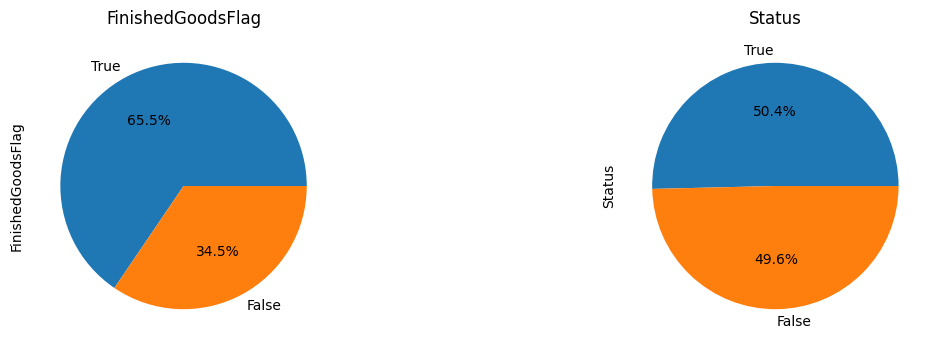

In [70]:
#Se crean dos graficos con los datos de FinishedGoodsFlag y Status
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = products['FinishedGoodsFlag'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0])
ax.set_title('FinishedGoodsFlag')

ax=products_true['Status'].isnull().value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
ax.set_title('Status')




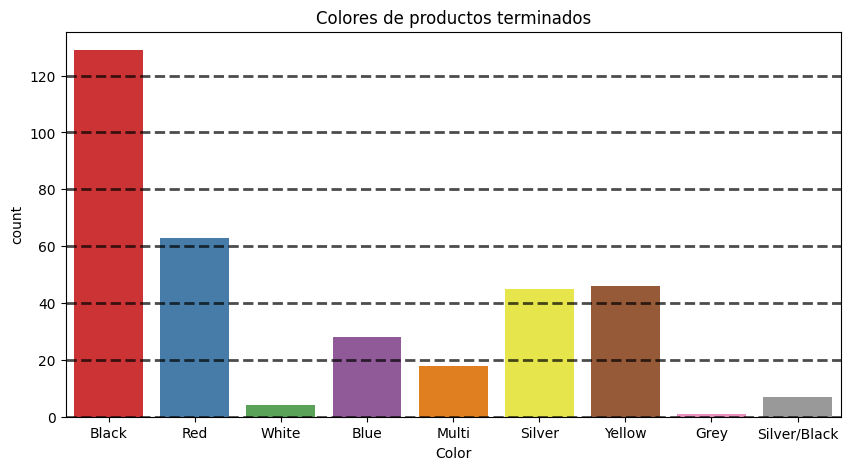

In [71]:
plt.figure(figsize=(10,5))
sns.countplot(x='Color',data=products_true,palette='Set1')
plt.title('Colores de productos terminados')
plt.grid(color='black', linestyle='--',linewidth=2, axis='y', alpha=0.7)
plt.show()